# Predicting Brain Pathology in Alzheimer's Disease using Elastic Net Regression

The notebook details an analysis using elastic net regression to predict brain pathology in Alzheimer's disease based on clinical features. It includes data processing, modeling, and evaluation steps. The analysis aims to create a baseline model for future comparisons with more complex approaches.

- Data  
    - Features: Clinical features include cognitive test scores, underlying health conditions, demographic.... 
    - Outcome: Pathology profiling includes amyloid, tangles, gpath, and NIA-Reagan scores.

# Analysis Steps
- Check Data
    - Correlation Analysis:
      - Identified 40 features with Pearson correlation coefficients > 0.4. Displayed results via a correlation heatmap.
- Data Preparation
    - Splitting data into 80% training and 20% testing sets.
    - Scaling features for model input.
- Elastic-Net Regression Used participants' last visit data.
    - Parameter Tuning: GridSearchCV to optimize hyperparameters.
    - Model Fitting: Applied best parameters to fit the elastic net model.
    - Performance Evaluation: Evaluated the model on testing data.
- Dimensionality Reduction with PCA
  - Applied PCA for feature reduction.
  - Re-ran elastic net regression using PCA-transformed data.

# Set up

In [23]:
import utils
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

# Load data

# 2. Perform GLM elastic-net using last visit

## 2.1 Parameter Tuning with GridSearchCV

In [35]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Define the parameter grid
param_grid = {
    'alpha': np.logspace(-3, 0, 10).astype(float).round(3),
    'l1_ratio': np.arange(0.0, 0.45, 0.05).astype(float).round(2)
}

# Use the custom model wrapper
elastic_net_ridge_switcher = utils.ElasticNetRidgeSwitcher()

# GridSearchCV
grid_search = GridSearchCV(
    estimator=elastic_net_ridge_switcher,
    param_grid=param_grid,
    scoring='r2',
    cv=5,  # Number of cross-validation folds
    n_jobs=-1  # Use all available cores
)

# Fit the grid search
grid_search.fit(train_predictors, gpath_outcome)
cv_results = pd.DataFrame(grid_search.cv_results_)

## 2.2 Check GridSearchCV results

In [37]:
# Columns of interest
columns_of_interest = [
    'param_alpha', 'param_l1_ratio',
    'mean_test_score', 'std_test_score'
]

# Filter results for readability
filtered_results = cv_results[columns_of_interest]
filtered_results.sort_values(by='mean_test_score', ascending=False)

,param_alpha,param_l1_ratio,mean_test_score,std_test_score
60,0.100,0.30,0.258885,0.072342
59,0.100,0.25,0.258477,0.075508
61,0.100,0.35,0.258381,0.070574
53,0.046,0.40,0.257166,0.085158
58,0.100,0.20,0.256876,0.079638
...,...,...,...,...
85,1.000,0.20,0.125988,0.021728
86,1.000,0.25,0.094322,0.017104
87,1.000,0.30,0.057920,0.018034
88,1.000,0.35,0.028638,0.021726


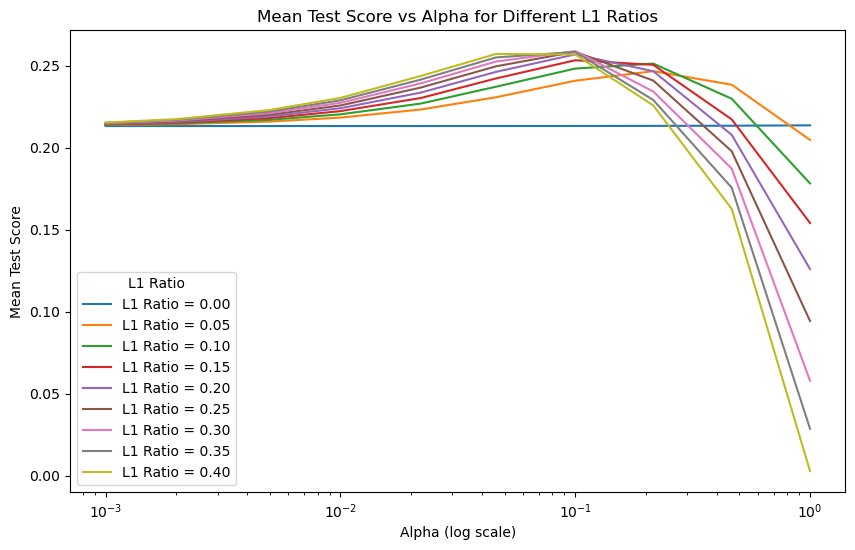

In [38]:
df = cv_results
plt.figure(figsize=(10, 6))
for l1_ratio in df["param_l1_ratio"].unique():
    subset = df[df["param_l1_ratio"] == l1_ratio]
    plt.plot(subset["param_alpha"], subset["mean_test_score"], label=f"L1 Ratio = {l1_ratio:.2f}")

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Alpha for Different L1 Ratios")
plt.legend(title="L1 Ratio")
plt.show()

## 2.3 Fit model with selected best parameters

In [39]:
# Best parameters and results
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best R-squared: {grid_search.best_score_:.4f}")

Best Parameters: {'alpha': 0.1, 'l1_ratio': 0.3}
Best R-squared: 0.2589


In [40]:
# Rebuild the model with the best parameters
best_model = utils.ElasticNetRidgeSwitcher(
    alpha=grid_search.best_params_['alpha'], 
    l1_ratio=grid_search.best_params_['l1_ratio'], 
    max_iter=10000
)

# Fit the model on the entire training data
best_model.fit(train_predictors, gpath_outcome)

ElasticNetRidgeSwitcher(alpha=0.1, l1_ratio=0.3)

## 2.6 Check performance on testing data

In [41]:
# Predict on the test data
test_predictors = scaled_test_last.drop(columns=drop_vars)
y_pred = best_model.predict(test_predictors)

# Define the target outcome
y_test = scaled_test_last['gpath']

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared on test data: {r2:.4f}")

R-squared on test data: 0.2619


## 3. Perform GLM elastic-net using last visit with PCA to perform dimension reduction

In [42]:
pca = PCA(n_components=2)
components = pca.fit_transform(train_predictors)

loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Define a threshold for displaying names
threshold = 0.4  # Adjust this value as needed

# Create a dummy DataFrame for scatter plot
dummy_df = pd.DataFrame({'PC1': [0], 'PC2': [0]})  # Placeholder for empty scatter

# Create the scatter plot
fig = px.scatter(dummy_df, x='PC1', y='PC2')  # No actual data points shown

# Add loadings as annotations
for i, feature in enumerate(train_predictors.columns):
    magnitude = np.linalg.norm(loadings[i])  # Calculate the magnitude of the loading
    if magnitude > threshold:  # Only show names for large loadings
        fig.add_annotation(
            ax=0, ay=0,
            axref="x", ayref="y",
            x=loadings[i, 0],
            y=loadings[i, 1],
            showarrow=True,
            arrowsize=2,
            arrowhead=2,
            xanchor="right",
            yanchor="top"
        )
        fig.add_annotation(
            x=loadings[i, 0],
            y=loadings[i, 1],
            ax=0, ay=0,
            xanchor="center",
            yanchor="bottom",
            text=feature,
            yshift=5,
        )

# Show the plot
fig.show()

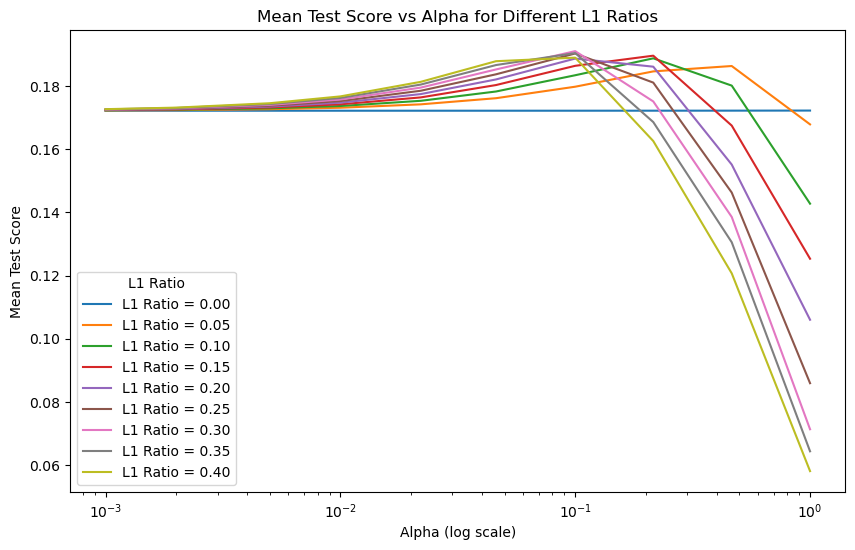

In [43]:
pca = PCA(n_components=20)
train_pcs = pca.fit_transform(train_predictors)

grid_search.fit(train_pcs, gpath_outcome)
cv_results = pd.DataFrame(grid_search.cv_results_)

df = cv_results
plt.figure(figsize=(10, 6))
for l1_ratio in df["param_l1_ratio"].unique():
    subset = df[df["param_l1_ratio"] == l1_ratio]
    plt.plot(subset["param_alpha"], subset["mean_test_score"], label=f"L1 Ratio = {l1_ratio:.2f}")

plt.xscale("log")
plt.xlabel("Alpha (log scale)")
plt.ylabel("Mean Test Score")
plt.title("Mean Test Score vs Alpha for Different L1 Ratios")
plt.legend(title="L1 Ratio")
plt.show()

In [44]:
best_model = utils.ElasticNetRidgeSwitcher(
    alpha=grid_search.best_params_['alpha'], 
    l1_ratio=grid_search.best_params_['l1_ratio'], 
    max_iter=10000
)

# Fit the model on the entire training data
best_model.fit(train_pcs, gpath_outcome)

# Predict on the test data
test_predictors = scaled_test_last.drop(columns=drop_vars)
test_pcs = pca.transform(test_predictors)
y_pred = best_model.predict(test_pcs)

# Define the target outcome
y_test = scaled_test_last['gpath']

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f"R-squared on test data: {r2:.4f}")

R-squared on test data: 0.1914
